In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from geopy.geocoders import Nominatim
import time
import folium
from folium import Choropleth, Circle, Marker

In [94]:
df = pd.read_excel('datasets/202410_KI_Soil test data.xlsx', skiprows=1)

In [95]:
df.head()

,Order ID,Crop Name,Crop Variety Name,Crop Class Name,Device Serial Number,Target Yield,Target Yield Unit,Tree Count,Scanner User Email,Client Name,...,2nd Application - Requirement (1).1,2nd Application - Type fertilizer (1).1,1st Application.2,1st Application - Requirement (1).2,1st Application - Type fertilizer (1).2,1st Application - Requirement (2).2,1st Application - Type fertilizer (2).2,2nd Application.2,2nd Application - Requirement (1).2,2nd Application - Type fertilizer (1).2
0,1162716,maize (corn),Maize (corn),plant hole,SC1919E,0,kg,0,kennet@kumva.io,AEE Nyaruguru,...,20.0,Calcium Nitrate,At Planting,20.0,40N+5.5S,130.0,SSP,6 weeks after,15.0,24N+6S
1,1162716,field bean,Field bean,plant hole,SC1919E,0,kg,0,kennet@kumva.io,AEE Nyaruguru,...,NaN,NaN,At Planting,30.0,24N+6S,115.0,SSP,NaN,NaN,NaN
2,1162716,potato,Potato,plant hole,SC1919E,0,kg,0,kennet@kumva.io,AEE Nyaruguru,...,15.0,CAN (26%N),At Planting,35.0,24N+6S,130.0,SSP,6 weeks after,25.0,Calcium Nitrate
3,1162716,cabbage,Cabbage,plant hole,SC1919E,0,kg,0,kennet@kumva.io,AEE Nyaruguru,...,35.0,Calcium Nitrate,At Planting,35.0,40N+5.5S,135.0,SSP,6 weeks after,25.0,24N+6S
4,1162716,onion,Onion,plant hole,SC1919E,0,kg,0,kennet@kumva.io,AEE Nyaruguru,...,5.0,Urea (46%N),At Planting,15.0,40N+5.5S,135.0,SSP,6 weeks after,10.0,CAN (26%N)


In [96]:
# Step 1: Drop duplicates based on relevant columns to avoid repetition
unique_columns = ['Field Name', 'Crop Name', 'Crop Variety Name']
df_cleaned = df.drop_duplicates(subset=unique_columns)

# Step 2: Handle missing values (filling with median for numeric columns)
df_cleaned.fillna(df_cleaned.median(numeric_only=True), inplace=True)

# Step 3: Identify numeric and non-numeric columns
numeric_cols = df_cleaned.select_dtypes(include='number').columns
non_numeric_cols = ['Crop Name', 'Crop Variety Name', 'Field Name']

# Step 4: Group by 'Crop Name' and aggregate numeric data using mean
# We don't aggregate 'Crop Name' explicitly, and avoid re-adding it
df_grouped = df_cleaned.groupby('Crop Name').agg({**{col: 'mean' for col in numeric_cols},
                                                  **{col: 'first' for col in non_numeric_cols if col != 'Crop Name'}}).reset_index()


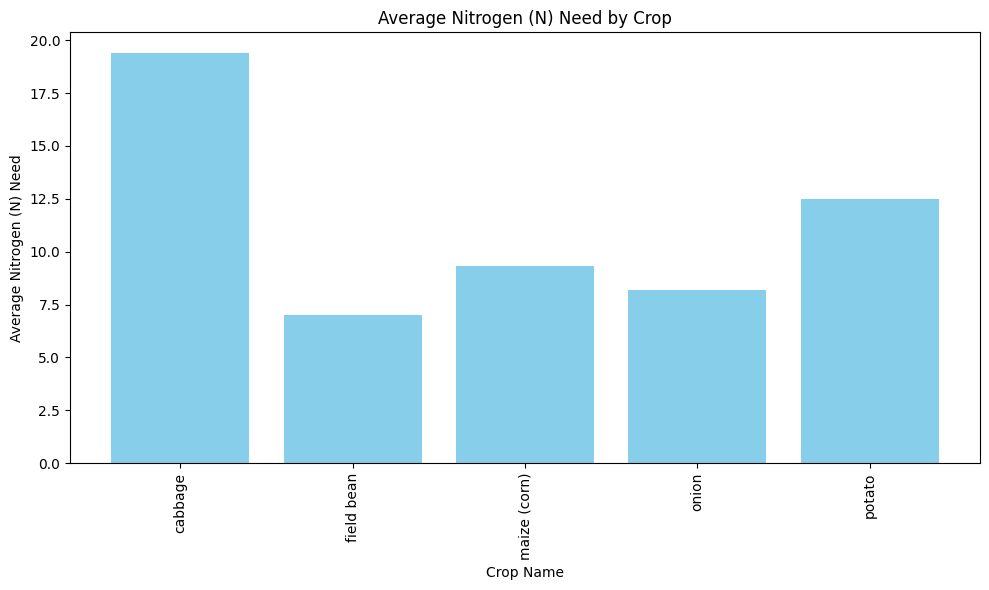

In [97]:
# Step 5: Visualize averages for each crop (e.g., pH levels, Nitrogen levels)
plt.figure(figsize=(10,6))
plt.bar(df_grouped['Crop Name'], df_grouped['Nitrogen (N) Need'], color='skyblue')
plt.xlabel('Crop Name')
plt.ylabel('Average Nitrogen (N) Need')
plt.title('Average Nitrogen (N) Need by Crop')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Step 6: Save the processed data to a CSV file for further use or model preparation
# df_grouped.to_csv('cleaned_crop_data.csv', index=False)

In [116]:
import pandas as pd
import folium
import geopandas as gpd

# Load the dataset
df = pd.read_excel('datasets/202410_KI_Soil test data.xlsx', skiprows=1)

# Step 1: Drop duplicates based on relevant columns
unique_columns = ['Field Name', 'Crop Name', 'Field Latitude', 'Field Longitude']
df_cleaned = df.drop_duplicates(subset=unique_columns)

# Step 2: Handle missing values by filling numeric columns with median
df_cleaned.fillna(df_cleaned.median(numeric_only=True), inplace=True)

# Step 3: Filter the relevant columns needed for mapping
df_map = df_cleaned[['Field Name', 'Crop Name', 'Total Nitrogen', 'Phosphorus (M3)', 'Field Latitude', 'Field Longitude']]

# Step 4: Load the Rwanda GeoJSON file (assumed to be in the current directory)
rwanda_geojson = 'datasets/geoBoundaries-RWA-ADM0_simplified.geojson'  # You need to provide the correct path to this file

# Step 5: Create the base map centered on Rwanda
m = folium.Map(location=[-1.9403, 29.8739], zoom_start=8)

# Step 6: Add a choropleth layer for Nitrogen levels
folium.Choropleth(
    geo_data=rwanda_geojson,
    data=df_map,
    columns=['Field Name', 'Total Nitrogen'],  # Field name as an index, Nitrogen as value
    key_on='feature.properties.name',  # Assumes the GeoJSON has 'name' for regions
    fill_color='YlGn',  # Yellow to green color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total Nitrogen Levels',
).add_to(m)

# Step 7: Add a choropleth layer for Phosphorus levels
folium.Choropleth(
    geo_data=rwanda_geojson,
    data=df_map,
    columns=['Field Name', 'Phosphorus (M3)'],  # Field name as an index, Phosphorus as value
    key_on='feature.properties.name',  # Assumes the GeoJSON has 'name' for regions
    fill_color='BuPu',  # Blue to purple color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Phosphorus (M3) Levels',
).add_to(m)

# Step 8: Add tooltips or popups if needed (optional)
for _, row in df_map.iterrows():
    popup_text = f"""
    <b>Field:</b> {row['Field Name']}<br>
    <b>Crop:</b> {row['Crop Name']}<br>
    <b>Total Nitrogen:</b> {row['Total Nitrogen']}<br>
    <b>Phosphorus (M3):</b> {row['Phosphorus (M3)']}
    """
    folium.Marker(
        location=[row['Field Latitude'], row['Field Longitude']],
        popup=popup_text
    ).add_to(m)

# Step 9: Save the map as an HTML file to view it
m.save('Rwanda_Nitrogen_Phosphorus_Map.html')

# Display the map inline (if using a Jupyter Notebook or similar environment)
m


ValueError: key_on `'properties.name'` not found in GeoJSON.

In [98]:
# # Initialize the geocoder
# geolocator = Nominatim(user_agent="geoapiExercises")

In [99]:
# # Function to get location (region name) from latitude and longitude
# def get_location_name(lat, lon):
#     try:
#         location = geolocator.reverse((lat, lon), language='en', timeout=10)
#         return location.address.split(",")[-3] if location else "Unknown location"  # You can adjust this based on your required granularity
#     except:
#         return "Unknown location"

In [100]:
# # Add region to the dataset
# df['Field Region'] = df.apply(lambda row: get_location_name(row['Field Latitude'], row['Field Longitude']), axis=1)

# # Saving the processed data with regions to a new file
# df.to_csv('processed_data_with_regions.csv', index=False)

In [101]:
# # Drop duplicate crops based on crop name, variety, and field location
# df_cleaned = df.drop_duplicates(subset=['Crop Name', 'Crop Variety Name', 'Field Latitude', 'Field Longitude'])

# # Preview cleaned dataset
# df_cleaned.head()

In [102]:
# # Drop rows with missing latitude or longitude
# df_cleaned = df_cleaned.dropna(subset=['Field Latitude', 'Field Longitude'])

# # Fill missing data (e.g., 'Tree Count' or 'Target Yield') with default values or based on domain knowledge
# df_cleaned['Tree Count'].fillna(0, inplace=True)

In [103]:
# # Crop count by region
# crop_region = df_cleaned.groupby('Field Region')['Crop Name'].count().reset_index()

In [104]:
# # Plot crops per region
# plt.figure(figsize=(12, 6))
# sns.barplot(x='Field Region', y='Crop Name', data=crop_region)
# plt.xticks(rotation=90)
# plt.title('Number of Crops per Region')
# plt.xlabel('Region')
# plt.ylabel('Crop Count')
# plt.show()

In [105]:
# # Distribution of field sizes
# plt.figure(figsize=(10, 6))
# sns.histplot(df_cleaned['Field Size'], bins=20, kde=True)
# plt.title('Field Size Distribution')
# plt.xlabel('Field Size (units: acres/hectares)')
# plt.ylabel('Frequency')
# plt.show()

In [106]:
# # Nitrogen content per region
# nitrogen_region = df_cleaned.groupby('Field Region')['Total Nitrogen'].mean().reset_index()

# plt.figure(figsize=(8, 4))
# sns.barplot(x='Field Region', y='Total Nitrogen', data=nitrogen_region)
# plt.xticks(rotation=90)
# plt.title('Average Nitrogen Content by Region')
# plt.xlabel('Region')
# plt.ylabel('Average Total Nitrogen')
# plt.show()

In [107]:
# # Remove rows with missing NPK values
# df_cleaned = df.dropna(subset=['Nitrogen (N) Need', 'Phosphorus (P2O5) Need', 'Potassium (K2O) Need'])

In [108]:
# # Group by crop name and calculate the average NPK needs
# npk_summary = df_cleaned.groupby('Crop Name')[['Nitrogen (N) Need', 'Phosphorus (P2O5) Need', 'Potassium (K2O) Need']].mean()

# # Reset the index for easy plotting
# npk_summary.reset_index(inplace=True)

In [109]:
# # Set the figure size
# plt.figure(figsize=(12, 8))

# # Plot NPK data for each crop
# sns.set(style="whitegrid")

# # Create a grouped bar chart
# npk_summary.plot(
#     x='Crop Name',
#     kind='bar',
#     stacked=False,
#     color=['#1f77b4', '#ff7f0e', '#2ca02c'],  # Blue for Nitrogen, Orange for Phosphorus, Green for Potassium
#     figsize=(12, 8)
# )

# plt.title("NPK Needs by Crop", fontsize=16)
# plt.xlabel("Crop Name", fontsize=12)
# plt.ylabel("NPK Needs", fontsize=12)
# plt.xticks(rotation=45, ha='right')
# plt.legend(title="NPK Elements", fontsize=12)
# plt.tight_layout()

# # Show the plot
# plt.show()

In [110]:
# # Drop rows where any NPK data is missing
# df_cleaned = df.dropna(subset=[
#     'Total Nitrogen_Min', 'Total Nitrogen_Max', 'Nitrogen (N) Need',
#     'Phosphorus (M3)_Min', 'Phosphorus (M3)_Max', 'Phosphorus (P2O5) Need',
#     'Potassium (exch.)_Min', 'Potassium (exch.)_Max', 'Potassium (K2O) Need'
# ])

In [111]:
# # Group by Crop Name and calculate averages for NPK
# npk_summary = df_cleaned.groupby('Crop Name').agg({
#     'Nitrogen (N) Need': 'mean',
#     'Total Nitrogen_Min': 'mean',
#     'Total Nitrogen_Max': 'mean',
#     'Phosphorus (P2O5) Need': 'mean',
#     'Phosphorus (M3)_Min': 'mean',
#     'Phosphorus (M3)_Max': 'mean',
#     'Potassium (K2O) Need': 'mean',
#     'Potassium (exch.)_Min': 'mean',
#     'Potassium (exch.)_Max': 'mean'
# }).reset_index()

In [112]:
# # Set figure size
# plt.figure(figsize=(14, 8))

# # Calculate the error bars for Nitrogen, Phosphorus, and Potassium (ensure no negative values)
# nitrogen_yerr = [
#     np.maximum(0, npk_summary['Nitrogen (N) Need'] - npk_summary['Total Nitrogen_Min']),
#     np.maximum(0, npk_summary['Total Nitrogen_Max'] - npk_summary['Nitrogen (N) Need'])
# ]

# phosphorus_yerr = [
#     np.maximum(0, npk_summary['Phosphorus (P2O5) Need'] - npk_summary['Phosphorus (M3)_Min']),
#     np.maximum(0, npk_summary['Phosphorus (M3)_Max'] - npk_summary['Phosphorus (P2O5) Need'])
# ]

# potassium_yerr = [
#     np.maximum(0, npk_summary['Potassium (K2O) Need'] - npk_summary['Potassium (exch.)_Min']),
#     np.maximum(0, npk_summary['Potassium (exch.)_Max'] - npk_summary['Potassium (K2O) Need'])
# ]

# # Create a bar plot with error bars for Nitrogen (N)
# plt.bar(npk_summary['Crop Name'], npk_summary['Nitrogen (N) Need'], 
#         yerr=nitrogen_yerr, label='Nitrogen (N) Need', color='#1f77b4', alpha=0.7)

# # Plot Phosphorus (P)
# plt.bar(npk_summary['Crop Name'], npk_summary['Phosphorus (P2O5) Need'], 
#         yerr=phosphorus_yerr, label='Phosphorus (P2O5) Need', color='#ff7f0e', alpha=0.7)

# # Plot Potassium (K)
# plt.bar(npk_summary['Crop Name'], npk_summary['Potassium (K2O) Need'], 
#         yerr=potassium_yerr, label='Potassium (K2O) Need', color='#2ca02c', alpha=0.7)

# # Add labels and title
# plt.title('NPK Needs with Min-Max Ranges per Crop', fontsize=16)
# plt.xlabel('Crop Name', fontsize=12)
# plt.ylabel('NPK Need and Range', fontsize=12)
# plt.xticks(rotation=45, ha='right')
# plt.legend(title="NPK Elements", fontsize=12)
# plt.tight_layout()

# # Show the plot
# plt.show()